<a href="https://www.kaggle.com/code/sharanharsoor/analysing-imdb-reviews?scriptVersionId=122397263" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 0. Introduction.
This notebook will do basic IMDB reviews sentiment analysis. As show in below image, we will be performing few text cleaning and model building techniques. The flow of the notebook.

1. Import libraries 
2. Read input data
3. Preprocessing IMDB Reviews <br>
    3.1 function to removes pattern in the input text <br>
    3.2 Collating all functions together and applying them for the ‘IMDb reviews’ dataset <br>
    3.3. Removing stopwords <br>
    3.4 Stemming and Lemmatization <br>
    3.5 Observation  <br>
4. Exploratory Data Analysis
5. Model creation 
    5.1 Data preparation <br>
    5.2 Bag of words model <br>
    5.3 TF-IDF model <br>
6. Model Comparison
    6.1 Observation <br>
7. TextBlob library

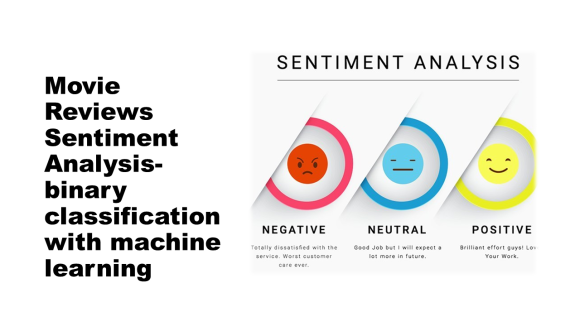


# 1.Import libraries
To start off, you will import the required libraries for visualising and analysing the text data.
In particular, Beautiful Soup is a commonly used Python library for parsing HTML and XML files.

In [1]:
import pandas as pd
import numpy as np
import re #used as a regular expression to find particular patterns and process it
import string #used to obtain information in the string and manipulate the string overall
import warnings
import re
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from textblob import TextBlob
# plotting
import seaborn as sns
import matplotlib.pyplot as plt
# nltk
import nltk #a natural language processing toolkit module associated in anaconda
from nltk.corpus import stopwords
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,SnowballStemmer
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('omw-1.4')
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline
warnings.filterwarnings('ignore')



[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


# 2. Read input data

In [2]:
imdb=pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
print(imdb.shape)
imdb.head(10)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


# 3. Preprocessing IMDB Reviews

# 3.1 function to removes pattern in the input text

In [3]:
# fucntion to removes pattern in the input text.

def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for word in r:
        input_txt = re.sub(word, "", input_txt)
    return input_txt


imdb['review'] = np.vectorize(remove_pattern)(imdb['review'], "@[\w]*")

## 3.2  Collating all functions together and applying them for the 'IMDb reviews' dataset


In [4]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Removing emojis
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols                                                                         
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

# Text-encoding: UTF-8 encoder
def to_unicode(text):
    if isinstance(text, float):
        text = str(text)
    if isinstance(text, int):
        text = str(text)
    if not isinstance(text, str):
        text = text.decode('utf-8', 'ignore')
    return text

# Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

# Removing the noisy text
def denoise_text(text):
    text = to_unicode(text)
    text = strip_html(text)
    text = re.sub(r"http\S+", "", text)
    text = deEmojify(text)
    text = text.encode('ascii', 'ignore')
    text = to_unicode(text)
    text = remove_between_square_brackets(text)
    text = remove_special_characters(text)
    text = text.lower() # lower case 
    return text


In [5]:
#Raw example of a randomly selected review

imdb['review'][111]

"I liked Boyle's performance, but that's about the only positive thing I can say. Everything was overdone to the point of absurdity. Most of the actors spoke like you would expect your 9-year-old nephew to speak if he were pretending to be a jaded, stone-hearted cop, or an ultra-evil villain. The raspy voice-overs seemed amateurish to me. I could go buy a cheap synthesizer and crank out better opening music. And what's with the whole 1984ish police torture stuff? It was totally superfluous and had nothing to do with the actual events of the story. Cox added a lot of things, in fact, that he apparently thought would be really cool, but had nothing to do with the story. That's a big disappointment because one of the things that makes Borges' stories so good is his minimalism -- they are tightly bound, with no superfluous details. This movie is just the opposite. I stopped watching after the scene where Lonnrot is questioning the guy from the Yidische Zaitung, or thereabouts. I wasted $4 

In [6]:
#Apply function on review column

imdb['review']=imdb['review'].apply(denoise_text)
imdb['review'].head()

0    one of the other reviewers has mentioned that ...
1    a wonderful little production the filming tech...
2    i thought this was a wonderful way to spend ti...
3    basically theres a family where a little boy j...
4    petter matteis love in the time of money is a ...
Name: review, dtype: object

In [7]:
#Processed example of a randomly selected review

imdb['review'][111]

'i liked boyles performance but thats about the only positive thing i can say everything was overdone to the point of absurdity most of the actors spoke like you would expect your 9yearold nephew to speak if he were pretending to be a jaded stonehearted cop or an ultraevil villain the raspy voiceovers seemed amateurish to me i could go buy a cheap synthesizer and crank out better opening music and whats with the whole 1984ish police torture stuff it was totally superfluous and had nothing to do with the actual events of the story cox added a lot of things in fact that he apparently thought would be really cool but had nothing to do with the story thats a big disappointment because one of the things that makes borges stories so good is his minimalism  they are tightly bound with no superfluous details this movie is just the opposite i stopped watching after the scene where lonnrot is questioning the guy from the yidische zaitung or thereabouts i wasted 4 renting this but at least i can 

## 3.3. Removing stopwords

In [8]:
#Tokenization of text
tokenizer=ToktokTokenizer() #for every function

#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

In [9]:
from nltk.tokenize import word_tokenize,sent_tokenize

#You can either remove stopwords before or after stemming. But since this is a review context, we expect users to have used many different words and we did
# stemming before filtering for stopwords.

stop=set(stopwords.words('english'))
print(stop)

#Removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

#Apply function on review column
imdb['review']=imdb['review'].apply(remove_stopwords)

{'such', 'which', 'yourselves', 'mightn', 'of', 'before', "doesn't", "should've", "hasn't", 'while', 'again', 'why', 'each', 'so', 'is', 'that', 'through', 'with', 'me', 'themselves', 'our', 'i', 'himself', 'theirs', "hadn't", "haven't", 'then', 'haven', 'hers', 'd', 'no', "needn't", "shouldn't", "mightn't", 'for', 'o', 'over', 's', 'once', 'were', 'own', 'couldn', 'them', 'it', 'after', 'do', 'into', 'on', 'more', 'very', 'other', 'can', 'not', 'too', 'in', 'if', 'during', 'aren', 'what', 'him', 'we', 'at', 'wasn', 'doesn', 'weren', 'some', 'he', 'shouldn', 'his', 'been', 'out', "wasn't", 'about', "isn't", "aren't", 'these', 'whom', 'shan', 'isn', 'few', 'hadn', 'ain', 'am', 'up', 'your', 'they', 'there', 'where', "she's", 'further', 'now', 'against', 'under', 'off', 'because', 'here', 'my', 'has', "you're", 'didn', 'm', 'myself', 'most', "wouldn't", 'between', 'itself', 'those', "shan't", 'herself', 'doing', 'an', 'a', 'will', 'the', "mustn't", 'she', 'from', 'but', 'below', "weren't

In [10]:
#Example of randomly selected review text
imdb['review'][678]

'adenoid hynkel lowly soldier world war one rises subsequent years become ruthless dictator toumania creates aggressive antisemitic war machine cultivates little toothbrush moustache sound like anyone knowfrom safety hollywood chaplin uses soapbox exhort europe take arms defy hitler mussolini given united states 1940 year neutrality ahead strong desire embroil europes civil strife remember hitler declared war usa way round surprising chaplin allowed distribute immoderate polemicthe story involves one hand vulgar repellant hynkel reign terror ineptly presides life jewish ghetto every single person friendly humane brave etc etc chaplin hynkel also plays jewish barber little hero ghetto tramp name needless say chaplin writes directs stars composes music cateringin 1940 full truth yet known third reich chaplin forgiven something less perfect historical foresight even standards day gets hitler badly wrong comedian sentimentalist chaplin tries ridicule hitler making hynkel silly hapless huma

## 3.4 Stemming and Lemmatization
Stemming is rule-based, it omits the last few letters like 'ing', 'ed', 'es' and more. It is fast but may create strange words.
Lemmatizing is dictionary-based, where it translates all words to the root form, like 'went' to 'go', 'going' to 'go' and more. 
Generally we prefer lemmatizing, but it might take some time in large datasets. 

In [11]:
def simple_stemmer(text):
    ps = SnowballStemmer(language='english')
    return ' '.join([ps.stem(word) for word in tokenizer.tokenize(text)])

In [12]:
imdb['review'][1]

'wonderful little production filming technique unassuming oldtimebbc fashion gives comforting sometimes discomforting sense realism entire piece actors extremely well chosen michael sheen got polari voices pat truly see seamless editing guided references williams diary entries well worth watching terrificly written performed piece masterful production one great masters comedy life realism really comes home little things fantasy guard rather use traditional dream techniques remains solid disappears plays knowledge senses particularly scenes concerning orton halliwell sets particularly flat halliwells murals decorating every surface terribly well done'

In [13]:
%time simple_stemmer(imdb['review'][1])

CPU times: user 1.9 ms, sys: 0 ns, total: 1.9 ms
Wall time: 2.02 ms


'wonder littl product film techniqu unassum oldtimebbc fashion give comfort sometim discomfort sens realism entir piec actor extrem well chosen michael sheen got polari voic pat truli see seamless edit guid refer william diari entri well worth watch terrif written perform piec master product one great master comedi life realism realli come home littl thing fantasi guard rather use tradit dream techniqu remain solid disappear play knowledg sens particular scene concern orton halliwel set particular flat halliwel mural decor everi surfac terribl well done'

In [14]:
#Lemmatizer example

def lemmatize_all(sentence):
    wnl = WordNetLemmatizer()
    for word, tag in pos_tag(word_tokenize(sentence)):
        if tag.startswith("NN"):
            yield wnl.lemmatize(word, pos='n')
        elif tag.startswith('VB'):
            yield wnl.lemmatize(word, pos='v')
        elif tag.startswith('JJ'):
            yield wnl.lemmatize(word, pos='a')
        else:
            yield word
            
def lemmatize_text(text):
    return ' '.join(lemmatize_all(text))

In [15]:
imdb['review'][1]

'wonderful little production filming technique unassuming oldtimebbc fashion gives comforting sometimes discomforting sense realism entire piece actors extremely well chosen michael sheen got polari voices pat truly see seamless editing guided references williams diary entries well worth watching terrificly written performed piece masterful production one great masters comedy life realism really comes home little things fantasy guard rather use traditional dream techniques remains solid disappears plays knowledge senses particularly scenes concerning orton halliwell sets particularly flat halliwells murals decorating every surface terribly well done'

In [16]:
%time lemmatize_text(imdb['review'][1])

CPU times: user 2.14 s, sys: 83.7 ms, total: 2.22 s
Wall time: 2.25 s


'wonderful little production film technique unassuming oldtimebbc fashion give comfort sometimes discomforting sense realism entire piece actor extremely well choose michael sheen get polari voice pat truly see seamless edit guided reference williams diary entry well worth watch terrificly write perform piece masterful production one great master comedy life realism really come home little thing fantasy guard rather use traditional dream technique remain solid disappears play knowledge sens particularly scene concern orton halliwell set particularly flat halliwells mural decorate every surface terribly well do'

## 3.5 Observation : 
observe that lemmatizer takes longer time compare to stemming. Using one of this method is a choice that depends on dataset sise, accuracy requiered etc. In this case will use lemmatizer for better accuracy.

In [17]:
imdb['review'] = imdb['review'].apply(lemmatize_text)

In [18]:
#Example of randomly selected review text

imdb['review'][1]

'wonderful little production film technique unassuming oldtimebbc fashion give comfort sometimes discomforting sense realism entire piece actor extremely well choose michael sheen get polari voice pat truly see seamless edit guided reference williams diary entry well worth watch terrificly write perform piece masterful production one great master comedy life realism really come home little thing fantasy guard rather use traditional dream technique remain solid disappears play knowledge sens particularly scene concern orton halliwell set particularly flat halliwells mural decorate every surface terribly well do'

# 4. Exploratory Data Analysis

positive    25000
negative    25000
Name: sentiment, dtype: int64


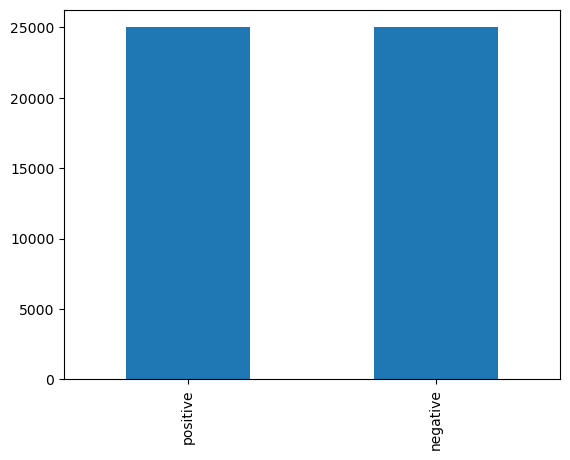

In [19]:
# Visualising the distribution of the target variable.

print(imdb.sentiment.value_counts())
imdb.sentiment.value_counts().plot(kind = 'bar')
plt.show()

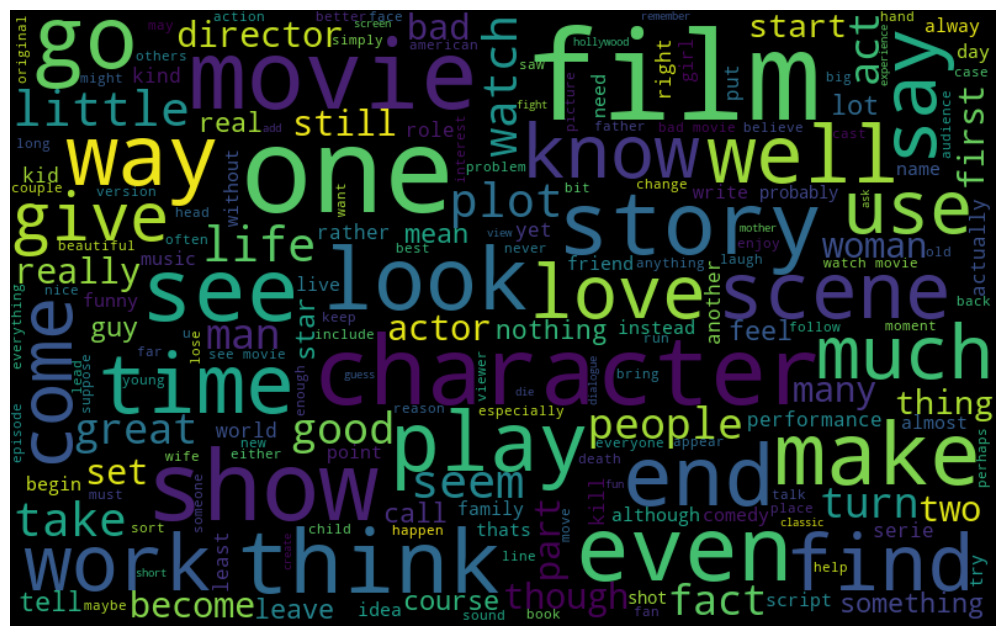

In [20]:
# visualize the frequent words

all_words = " ".join([sentence for sentence in imdb['review']])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


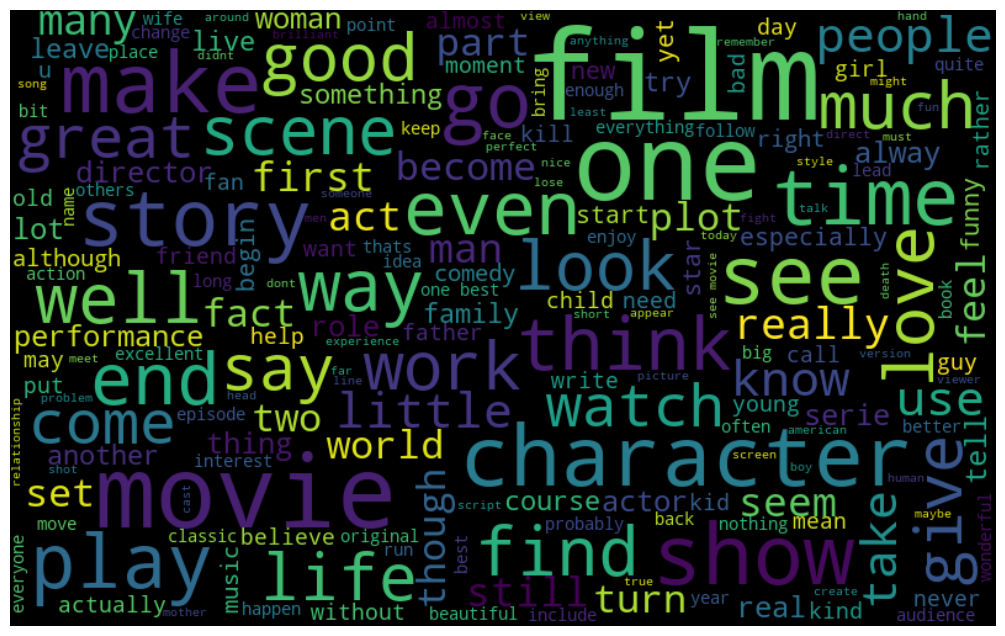

In [21]:
# frequent words visualization for +ve

all_words = " ".join([sentence for sentence in imdb['review'][imdb['sentiment']=='positive']])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


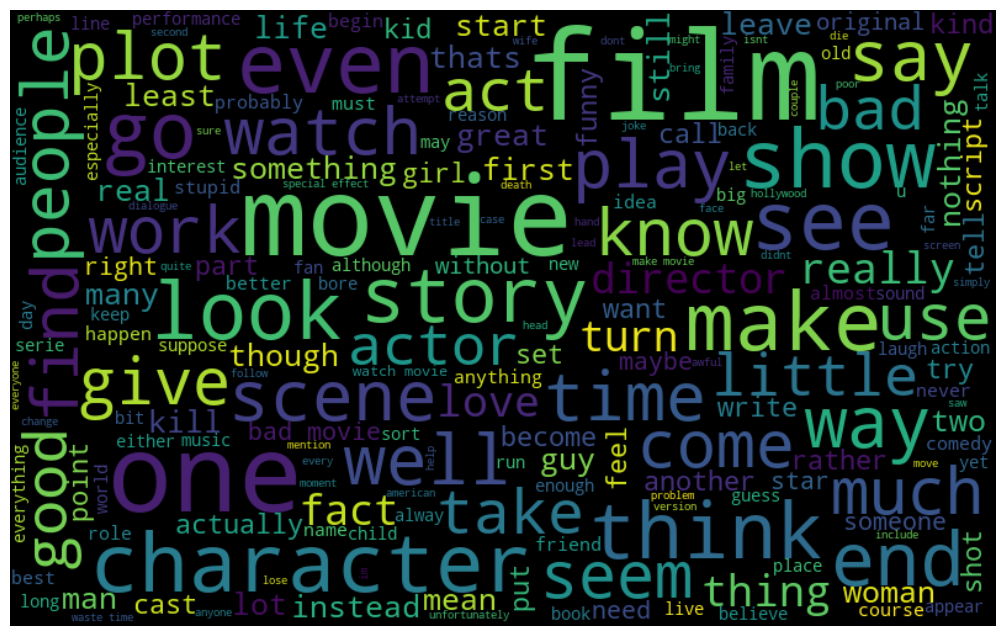

In [22]:
# frequent words visualization for -ve

all_words = " ".join([sentence for sentence in imdb['review'][imdb['sentiment']=='negative']])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


# 5. Model creation
Creating features using Bag of words model and building the Logistic Regression model

## 5.1 Data preparation

In [23]:
#Transformed train reviews

norm_reviews = imdb.review

In [24]:
# Binarisation of Sentiments: Positive: 1, Negative: 0

lb=LabelBinarizer()

#Transformed sentiment data
sentiment_data=lb.fit_transform(imdb['sentiment'])
print(sentiment_data.shape)

(50000, 1)


## 5.2 Bag of words model

In [25]:
#Creating a matrix with reviews in row and unique words as columns and frequency of word in review as values.
#Count vectorizer for bag of words
cv=CountVectorizer()

#Fitting model on entire data
cv_fit = cv.fit(norm_reviews)

Transform the train and the test dataset separately

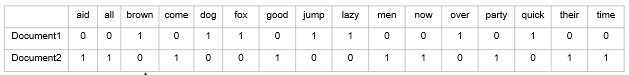!

In [26]:
#Normalised train reviews
norm_train_reviews=imdb.review[:45000]
print('train:','\n',norm_train_reviews[200])
norm_train_cv_reviews=cv_fit.transform(norm_train_reviews)

#Normalised test reviews
norm_test_reviews=imdb.review[45000:]
print('test:','\n',norm_test_reviews[45001])
norm_test_cv_reviews=cv_fit.transform(norm_test_reviews)

train: 
 interest short television movie describe machination surround jay lenos replace carson host tonight show film currently topical give public drama surround conan obrien jay lenothe film good job spark viewer interest event show concern stakeholder particularly nbc executive portrayal ovitz particularly compel interest thoughtstill many character briefly limn touched upon act seem perfunctory nevertheless interesting story
test: 
 macarthur great movie great story great mangeneral douglas macarthur course story one america great military figure figure make familiar early moment memory though continuity issue may others eg macarthur speech portray film 1962 address us military academy accept thayer award contain phrase old soldier never die fade away speech congress upon dismissal president truman 1951 alleged insubordination two see eye eye gregory peck impeckable general vowed would return philippines world war ii film move quickly easily general family staff begin second world

In [27]:
# Splitting the output variable (sentiments) into test and train

train_sentiments=sentiment_data[:45000]
test_sentiments=sentiment_data[45000:]

In [28]:
#Calculating sentiment count
imdb['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [29]:
# Model building using Bag of words model- Logistic Regression
lr = LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)

#Fitting the model for the bag of words
lr_bow=lr.fit(norm_train_cv_reviews,train_sentiments)
print(lr_bow)

LogisticRegression(C=1, max_iter=500, random_state=42)


In [30]:
#Predicting the model for bag of words

lr_bow_predict=lr.predict(norm_test_cv_reviews)
print(lr_bow_predict)

[1 1 0 ... 0 1 0]


## 5.3 TF-IDF model 
Creating features using TF-IDF model and building the Logistic Regression model

In [31]:
#Transformed train reviews
norm_reviews=imdb.review

In [32]:
#Term-frequencey * inverse document frequency matrix
from sklearn.feature_extraction.text import TfidfVectorizer

#Applying TF-IDF vectorizer
tv=TfidfVectorizer()

#Fitting model on entire data
tv_fit = tv.fit(norm_reviews)


Transform the train and the test dataset separately

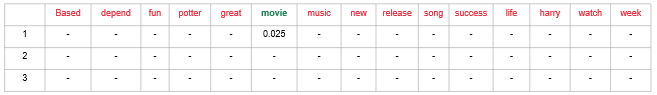

In [33]:
#Normalised train reviews
norm_train_reviews=imdb.review[:45000]
print('train:','\n',norm_train_reviews[0])
norm_train_tv_reviews=tv_fit.transform(norm_train_reviews)

#Normalised test reviews
norm_test_reviews=imdb.review[45000:]
print('test:','\n',norm_test_reviews[45001])
norm_test_tv_reviews=tv_fit.transform(norm_test_reviews)

train: 
 one reviewer mention watch 1 oz episode youll hook right exactly happen methe first thing strike oz brutality unflinching scene violence set right word go trust show faint hearted timid show pull punch regard drug sex violence hardcore classic use wordit call oz nickname give oswald maximum security state penitentary focus mainly emerald city experimental section prison cell glass front face inwards privacy high agenda em city home manyaryans muslims gangsta latino christian italian irish moreso scuffle death stare dodgy dealing shady agreement never far awayi would say main appeal show due fact go show wouldnt dare forget pretty picture paint mainstream audience forget charm forget romanceoz doesnt mess around first episode ever saw struck nasty surreal couldnt say ready watch developed taste oz get accustomed high level graphic violence violence injustice crook guard wholl sell nickel inmates wholl kill order get away well mannered middle class inmate turn prison bitch due l

In [34]:
norm_train_tv_reviews.shape

(45000, 210611)

In [35]:
# Splitting the output variable (sentiments) into test and train

train_sentiments=sentiment_data[:45000]
test_sentiments=sentiment_data[45000:]

In [36]:
# Model building using TF-IDF model- Logistic Regression
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)

#Fitting the model for tf-idf features
lr_tfidf=lr.fit(norm_train_tv_reviews,train_sentiments)
print(lr_tfidf)

LogisticRegression(C=1, max_iter=500, random_state=42)


In [37]:
# Predicting the model for tf-idf features

lr_tfidf_predict=lr.predict(norm_test_tv_reviews)
print(lr_tfidf_predict)

[1 1 0 ... 1 0 0]


# 6. Model Comparison

In [38]:
#Accuracy score for bag of words
lr_bow_score=accuracy_score(test_sentiments,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)

#Accuracy score for tfidf features
lr_tfidf_score=accuracy_score(test_sentiments,lr_tfidf_predict)
print("lr_tfidf_score :",lr_tfidf_score)

lr_bow_score : 0.8884
lr_tfidf_score : 0.8938


In [39]:
# Classification report for bag of words 
print("-----------------------BOW ------------------------------")
lr_bow_report=classification_report(test_sentiments,lr_bow_predict,target_names=['Positive','Negative'])
print(lr_bow_report)
print("-----------------------TFIDF ------------------------------")
#Classification report for tfidf features
lr_tfidf_report=classification_report(test_sentiments,lr_tfidf_predict,target_names=['Positive','Negative'])
print(lr_tfidf_report)

-----------------------BOW ------------------------------
              precision    recall  f1-score   support

    Positive       0.89      0.89      0.89      2530
    Negative       0.89      0.89      0.89      2470

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000

-----------------------TFIDF ------------------------------
              precision    recall  f1-score   support

    Positive       0.90      0.89      0.89      2530
    Negative       0.89      0.90      0.89      2470

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



In [40]:
# Confusion matrix for bag of words
print("-----------------------BOW ------------------------------")
cm_bow=confusion_matrix(test_sentiments,lr_bow_predict,labels=[1,0])
print(cm_bow)

#Confusion matrix for tfidf features
print("-----------------------TFIDF ------------------------------")
cm_tfidf=confusion_matrix(test_sentiments,lr_tfidf_predict,labels=[1,0])
print(cm_tfidf)

-----------------------BOW ------------------------------
[[2189  281]
 [ 277 2253]]
-----------------------TFIDF ------------------------------
[[2219  251]
 [ 280 2250]]


## 6.1 Observation :
From above model TF-IDF seems doing slightly better comapre to BOW.

# 7. TextBlob library
Introducing TextBlob library and predicting sentiment using TextBlob¶

In [41]:
# Create a function to get the polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

def getAnalysis(score):
    if score < 0:
        return "negative"
    else:
        return "positive"
    
imdb["textblob"] = imdb["review"].apply(getPolarity)
imdb["textblob_flag"] = imdb["textblob"].apply(getAnalysis)

In [42]:
print(len(imdb))
imdb.head(10)

50000


,review,sentiment,textblob,textblob_flag
0,one reviewer mention watch 1 oz episode youll ...,positive,0.024704,positive
1,wonderful little production film technique una...,positive,0.127604,positive
2,think wonderful way spend time hot summer week...,positive,0.291837,positive
3,basically there family little boy jake think t...,negative,-0.067188,negative
4,petter matteis love time money visually stunni...,positive,0.244476,positive
5,probably alltime favorite movie story selfless...,positive,0.222222,positive
6,sure would like see resurrection date seahunt ...,positive,0.207744,positive
7,show amazing fresh innovative idea 70s first a...,negative,0.119444,positive
8,encourage positive comment film look forward w...,negative,-0.211742,negative
9,like original gut wrench laughter like movie y...,positive,0.335000,positive


In [43]:
imdb["textblob_flag"] = lb.fit_transform(imdb["textblob_flag"])

In [44]:
#Classification report predictions from TextBlob
textblob_report = classification_report(test_sentiments,imdb["textblob_flag"][45000:],target_names=['Positive','Negative'])
print(textblob_report)

              precision    recall  f1-score   support

    Positive       0.87      0.44      0.59      2530
    Negative       0.62      0.93      0.75      2470

    accuracy                           0.69      5000
   macro avg       0.75      0.69      0.67      5000
weighted avg       0.75      0.69      0.67      5000



In [45]:
#Classification report for tfidf features
lr_tfidf_report = classification_report(test_sentiments, lr_tfidf_predict,target_names=['Positive','Negative'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.90      0.89      0.89      2530
    Negative       0.89      0.90      0.89      2470

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



In [46]:
# Confusion matrix for textblob
print("-----------------------textblob ------------------------------")
cm_textblob=confusion_matrix(test_sentiments,imdb["textblob_flag"][45000:],labels=[1,0])
print(cm_textblob)

#Confusion matrix for tfidf features
print("-----------------------TFIDF ------------------------------")
cm_tfidf=confusion_matrix(test_sentiments,lr_tfidf_predict,labels=[1,0])
print(cm_tfidf)

-----------------------textblob ------------------------------
[[2309  161]
 [1412 1118]]
-----------------------TFIDF ------------------------------
[[2219  251]
 [ 280 2250]]


# **** END ****